In [1]:
# To get precomputed clusterings
from pathlib import Path

if not Path("data/pbmc-clusterings.h5").is_file():
    !mkdir -p data
    !wget -O data/pbmc-clusterings.h5 https://cloudstor.aarnet.edu.au/plus/s/axjCBEL0ogP4u7s/download

--2020-12-09 14:15:05--  https://cloudstor.aarnet.edu.au/plus/s/axjCBEL0ogP4u7s/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22469819 (21M) [application/octet-stream]
Saving to: ‘data/pbmc-clusterings.h5’

data/pbmc-clusterin 100%[===================>]  21.43M  7.84MB/s    in 2.7s    

2020-12-09 14:15:08 (7.84 MB/s) - ‘data/pbmc-clusterings.h5’ saved [22469819/22469819]



In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import h5py

from constclust.aggregate import reconcile
import constclust

from bokeh.io import show, output_notebook

output_notebook()

Loading BokehJS ...

# Data

We'll be looking at some peripheral blood mononuclear cells (PBMCs). We'll be starting with pre-processed data (normalized, doublets removed) data. For the sake of demonstration, we've already computed clusters and assigned labels to this dataset, but we'll be showing the code for that process.

In [3]:
pbmc = sc.read(
    "data/pbmc-labelled.h5ad", 
    backup_url="https://cloudstor.aarnet.edu.au/plus/s/0Gvhip4f9QDYHY3/download"
)
pbmc

pbmc-labelled.h5ad: 228MB [00:26, 8.61MB/s]                              


AnnData object with n_obs × n_vars = 9936 × 23005
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden', 'suspected_doublets', 'lowlevel', 'highlevel', 'High-level celltypes', 'Low-level celltypes'
    var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'High-level celltypes_colors', 'Low-level celltypes_colors', 'highlevel_colors', 'leiden', 'leiden_colors', 'lowlevel_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## A quick look

Taking a first look at this data, we can see it does not cluster consistently with default parameters. Just changing the random state changes the assignments for some cells. In particular, there are random divisions that show up for the bottom right group.

In [4]:
sc.tl.leiden(pbmc, random_state=42, key_added="leiden_a")
sc.tl.leiden(pbmc, random_state=12, key_added="leiden_b")

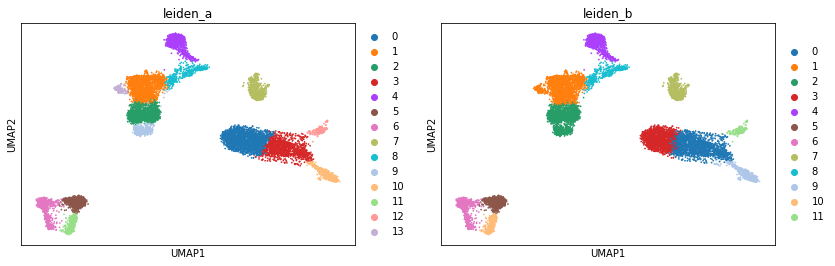

In [5]:
sc.pl.umap(pbmc, color=["leiden_a", "leiden_b"])

# Clustering

Since generating the clustering solutions for this data is computationally expensive, we'll be using precomputed values. These were generated by the following code:

```python
from constclust import cluster

# Making a smaller version of the object
to_cluster = sc.AnnData(
    X=sparse.csr_matrix(pbmc.shape),
    obsm={"X_pca": pbmc.obsm["X_pca"]}
)
params, clusterings = constclust.cluster(
    to_cluster,
    [10, 15, 25, 40, 60, 85, 115, 150, 190],
    np.geomspace(0.01, 100, 40),
    random_state=[0, 1, 2, 3],
    n_procs=12,
)
```

In [6]:
# Functions for saving and loading clustering data
def write_results(pth, params, clusterings):
    with h5py.File(pth, "w") as f:
        cluster_group = f.create_group("clusterings")
        cluster_group.create_dataset(
            "clusterings", data=clusterings.values, compression="lzf"
        )
        cluster_group.create_dataset(
            "obs_names", data=pbmc.obs_names.values, compression="lzf"
        )

        params_group = f.create_group("params")
        for k, v in params.items():
            params_group.create_dataset(k, data=v.values, compression="lzf")


def read_results(pth) -> "Tuple[pd.DataFrame, pd.DataFrame]":
    """Read params and clusterings which have been stored to disk."""
    with h5py.File(pth, "r") as f:
        params_group = f["params"]
        params = pd.DataFrame(
            {
                col: params_group[col]
                for col in ["n_neighbors", "resolution", "random_state"]
            }
        )
        cluster_group = f["clusterings"]
        clusterings = pd.DataFrame(
            cluster_group["clusterings"][()],
            index=cluster_group["obs_names"].asstr()[:],
        )
    return params, clusterings

In [7]:
# write_results("data/pbmc-clusterings.h5", params, clusterings)

In [8]:
params, clusterings = read_results("data/pbmc-clusterings.h5")

# Analysis

Now we'll be analyzing the clustering solutions. First we create the `Reconciler` object using the clustering solutions and their parameters (see more details on this process in `simulated.ipynb`)

In [9]:
%time rec = reconcile(params, clusterings)

CPU times: user 4.88 s, sys: 348 ms, total: 5.23 s
Wall time: 5.18 s


Distribution of Jaccard similarities between clusters found in neighbouring parameterizations:

<AxesSubplot:ylabel='Count'>

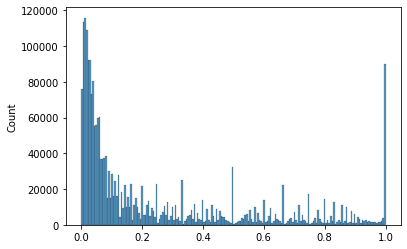

In [10]:
constclust.plotting.edge_weight_distribution(rec)

In [11]:
%time comps = rec.get_components(0.9, min_cells=5)

CPU times: user 13.4 s, sys: 92.1 ms, total: 13.5 s
Wall time: 13.5 s


## Plotting hierarchies

We can construct hierachies of the components found by looking at their membership. This creates a tree like structure that can make it easier to explore the data.

Using the method `.plot_hierarchies` all hierarchies that are found within a `ComponentList` are shown. There are shown as trees, where each node corresponds to a component. Hovering over the components shows the observations in each component plotted on the passed two dimensional embedding.

Some components may not be found in hierarchies (i.e. only one component in the `ComponentList` contained this set of observations). These are reported, but not shown.

In [12]:
show(
    comps
    .filter(min_solutions=100, min_intersect=10)
    .plot_hierarchies(pbmc.obsm["X_umap"])
)

Component 1 was not found in a hierarchy.
Component 2 was not found in a hierarchy.
Component 5 was not found in a hierarchy.
Component 6 was not found in a hierarchy.
Component 7 was not found in a hierarchy.
Component 10 was not found in a hierarchy.


Based off the labels in the hierarchies we can take a closer look at specific subsets. For example, looking at differences in parameter spaces for stable subsets of t-cells.

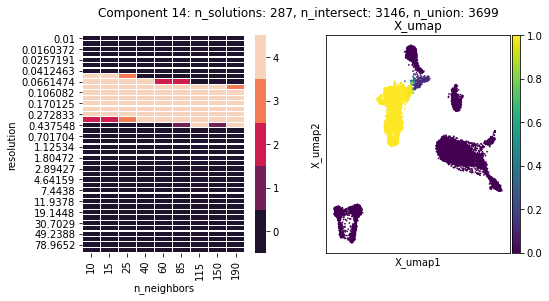

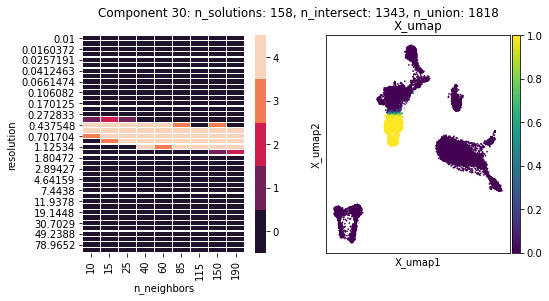

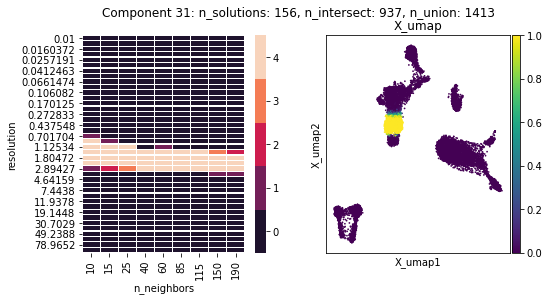

In [13]:
comps[[14, 30, 31]].plot_components(pbmc)

# Labelling

Labelling of clusterings was performed via marker genes through differential expression, literature search, and consulation with domain experts. A summary of this process, with marker genes and label assigments can be found in `collate_labels.ipynb`.

## Differential expression

While we won't go into the details of differential expression too much here, we can show that the clusters are distinct via differential expression.

In [14]:
# Computing DE
groups = list(pbmc.obs["Low-level celltypes"].cat.categories)
groups.remove("None")
sc.tl.rank_genes_groups(
    pbmc, groupby="Low-level celltypes", method="wilcoxon", groups=groups
)

In [15]:
de_dfs = {}
for cat in groups:
    de_dfs[cat] = sc.get.rank_genes_groups_df(pbmc, group=cat)

(
    pd.concat(de_dfs, names=["Low-level celltypes"])
    .query("pvals_adj <= 0.05")
    .groupby("Low-level celltypes")
    .apply(len)
    .min()
)

273

In [16]:
from sinfo import sinfo

sinfo()

-----
anndata     0.7.5
bokeh       2.2.3
constclust  v0.1.1+41.g3535166
h5py        3.1.0
matplotlib  3.3.3
numpy       1.19.4
pandas      1.1.4
scanpy      1.6.0
sinfo       0.3.1
-----
IPython             7.19.0
jupyter_client      6.1.7
jupyter_core        4.7.0
notebook            6.1.5
-----
Python 3.8.5 (default, Sep  4 2020, 02:22:02) [Clang 10.0.0 ]
macOS-10.15.7-x86_64-i386-64bit
16 logical CPU cores, i386
-----
Session information updated at 2020-12-09 14:16
